## Going through the process of understanding the data from the TC001
I will be going ahead and documenting sources, repos, etc. as I need them. Will try to keep the dependencies minimal - will list them out below as I need to.
Dependencies:
- OpenCV
- Numpy
- scikit-learn
- matplotlib
- pyvisa (For temperature controller)

**Note**: I am writing and testing this on windows at the moment, so it may break on Linux systems due to driver issues. The final product should be fairly platform-agnostic, though.

**Note 2**: I am slightly inconsisent when it comes to denoting the variables that I use, so:
- The data comprises of two 192x256 images, with each pixel having two values (v1,v2) associated with it. I use the prefixes im1 and im2 to denote the value I am talking about

### Getting Started
[This forum thread](https://www.eevblog.com/forum/thermal-imaging/infiray-and-their-p2-pro-discussion/200/) has most of the information regarding the TC001 and a very similar product called Infiray P2. Will mostly be going off of what some users here say to understand how the camera relays information.
**Note**: Ended up doing it from the ground up, did not have to rely on any external information.

In [66]:
import cv2
import numpy as np

dev = -1 #Camera ID - is normally zero if it is the only Cam connected

cam = cv2.VideoCapture(dev,cv2.CAP_ANY) #Creating the camera object, trying to request RAW

cam.set(cv2.CAP_PROP_CONVERT_RGB, 0.0) #Explicitly denying the RGB conversion

ret, frame = cam.read() #Reading a frame

if ret: #Capture successful
    print("Data about the frame ->")
    n_frame = np.asarray(frame)
    print(f'Shape of the frame - {n_frame.shape}')
else:
    print("Frame could not be captured successfully!")

Frame could not be captured successfully!


Interesting - the camera spits out a 1x196608 array - I assume that the two images that it is supposed to be giving out is flattened.

**NOTE:** If you have Topdon drivers installed, this will NOT work! Their drivers intentionally interfere with raw data extraction. Remedy? The cell below is me trying to deal with their drivers... trying to wrestle the data out.

In [11]:
#No need to run this cell if you have not installed Topdon Software
#Hence, these dependencies are only optional
import usb.core
import usb.util

devices = usb.core.find(find_all=True)

for dev in devices:
    print(f"Device: {dev}")
    print(f"  Vendor ID: {hex(dev.idVendor)}")
    print(f"  Product ID: {hex(dev.idProduct)}")
    print(f"  Device Address: {dev.address}")

Device: DEVICE ID 0bda:5830 on Bus 000 Address 255 =================
 bLength                :   0x12 (18 bytes)
 bDescriptorType        :    0x1 Device
 bcdUSB                 :  0x200 USB 2.0
 bDeviceClass           :   0xef Miscellaneous
 bDeviceSubClass        :    0x2
 bDeviceProtocol        :    0x1
 bMaxPacketSize0        :   0x40 (64 bytes)
 idVendor               : 0x0bda
 idProduct              : 0x5830
 bcdDevice              : 0x1101 Device 17.01
 iManufacturer          :    0x3 Generic
 iProduct               :    0x1 USB Camera
 iSerialNumber          :    0x2 200901010001
 bNumConfigurations     :    0x1
  CONFIGURATION 1: 500 mA ==================================
   bLength              :    0x9 (9 bytes)
   bDescriptorType      :    0x2 Configuration
   wTotalLength         :  0x166 (358 bytes)
   bNumInterfaces       :    0x2
   bConfigurationValue  :    0x1
   iConfiguration       :    0x4 USB Camera
   bmAttributes         :   0x80 Bus Powered
   bMaxPower          

The camera, with the driver installed, has two interfaces - one being normal UVC and the other being isochronous video in. UVC has minimum poll interval of 6ms. There are 7 alternate settings for the Isochornous In.

In [12]:
import time
import usb.backend.libusb1

VENDOR_ID = 0x0bda
PRODUCT_ID = 0x5830

# Set up the libusb1 backend
backend = usb.backend.libusb1.get_backend(find_library=None)
dev = usb.core.find(idVendor=VENDOR_ID, idProduct=PRODUCT_ID, backend=backend)

# Check if the device was found
if dev is None:
    raise ValueError("Device not found")
else:
    print("Device found!")

Device found!


In [13]:
dev.set_configuration() #Set up the configuration - there is only one here!

In [9]:
# Interrupt IN endpoint: 0x83 (IN direction, Interrupt transfer)
endpoint_interrupt_in = 0x83
max_packet_size_interrupt = 16  # Max packet size for this endpoint

# Read data from the interrupt endpoint (blocking)
try:
    data_interrupt = dev.read(endpoint_interrupt_in, max_packet_size_interrupt, timeout=1000)  # 1000ms timeout
    print(f"Received Interrupt Data: {data_interrupt}")
except usb.core.USBError as e:
    print(f"Error reading from interrupt endpoint: {e}")


Error reading from interrupt endpoint: [Errno None] b'libusb0-dll:err [claim_interface] could not claim interface 0, win error: Cannot create a file when that file already exists.\r\n'


Okay, clearly the Interrupt endpoint (0x83) has some issues. It times out.

In [14]:
dev.set_interface_altsetting(interface=1, alternate_setting=1)

# Isochronous IN endpoint: 0x81 (IN direction, Isochronous transfer)
endpoint_isochronous_in = 0x81

# Assume max packet size for the endpoint (this may vary depending on the alternate setting)
max_packet_size_isochronous = 128  # As per alternate setting 0 descriptor

# Read data from the Isochronous endpoint
try:
    data_isochronous = dev.read(endpoint_isochronous_in, max_packet_size_isochronous, timeout=1000)  # 1000ms timeout
    print(f"Received Isochronous Data: {data_isochronous}")
except usb.core.USBError as e:
    print(f"Error reading from isochronous endpoint: {e}")

Error reading from isochronous endpoint: [Errno None] b'libusb0-dll:err [_usb_reap_async] reaping request failed, win error: Incorrect function.\r\n\n'


Some problems with async calls - let us try sync calls for testing this out.

In [16]:
import usb.core
import usb.util
import time

# Vendor ID and Product ID for your camera device
VENDOR_ID = 0x0bda
PRODUCT_ID = 0x5830

# Find the device using PyUSB
dev = usb.core.find(idVendor=VENDOR_ID, idProduct=PRODUCT_ID)

# Check if the device was found
if dev is None:
    raise ValueError("Device not found")
else:
    print("Device found!")

# Set the active configuration (1st configuration, as per descriptor)
dev.set_configuration()

# Set the interface and alternate setting (for video streaming)
# From the device descriptor, interface 1 is the video interface
interface_number = 1
alternate_setting = 1  # Change to an alternate setting (e.g., 1, 2, etc.)
dev.set_interface_altsetting(interface=interface_number, alternate_setting=alternate_setting)

# The alternate setting determines which endpoint configuration is used.
# The correct endpoint should be selected based on the alternate setting.
# For example, in alternate setting 1, endpoint 0x81 is used for Isochronous IN.
endpoint_isochronous_in = 0x81  # This is an IN endpoint for alternate setting 1
max_packet_size_isochronous = 128  # Example size from alternate setting 0, adjust as needed

# Perform synchronous isochronous transfer (attempting to read data synchronously)
try:
    data_isochronous = dev.read(endpoint_isochronous_in, max_packet_size_isochronous, timeout=1000)  # 1000ms timeout
    print(f"Received Isochronous Data: {data_isochronous}")
except usb.core.USBError as e:
    print(f"Error reading from isochronous endpoint: {e}")

# Release the interface after use
usb.util.release_interface(dev, interface_number)

# Dispose of the device to clean up resources
usb.util.dispose_resources(dev)


Device found!
Error reading from isochronous endpoint: [Errno None] b'libusb0-dll:err [_usb_reap_async] reaping request failed, win error: Incorrect function.\r\n\n'


Still no luck. PyUSB probably will NOT work, maybe we should use something with more granular, low-level control. We could use libusbK bindings (if those are available).

In [34]:
import usb1 as libusb1
import time

# Vendor ID and Product ID for your camera device
VENDOR_ID = 0x0bda
PRODUCT_ID = 0x5830

# Find the device by Vendor ID and Product ID
device = None
with libusb1.USBContext() as context:
    device = context.openByVendorIDAndProductID(
        VENDOR_ID,
        PRODUCT_ID,
        skip_on_error=True,
    )
print(device)
if device is None:
    raise ValueError(f"Device with VID:{VENDOR_ID:X} PID:{PRODUCT_ID:X} not found!")

# Open the device
handle = device

# Claim the interface (assuming interface 1 is for video)
interface_number = 1
#handle.claimInterface(interface_number)

# Set the alternate setting for the video interface
alternate_setting = 1  # or whatever alternate setting you need
#handle.setInterfaceAltSetting(interface_number, alternate_setting)

# Define endpoint address for isochronous transfer (IN endpoint, typically 0x81 for isochronous IN)
endpoint_isochronous_in = 0x81
max_packet_size = 512  # Adjust according to the descriptor of your camera

# Start reading data from the isochronous endpoint
try:
    for i in range(5):  # Try 5 times for example
        data = handle.bulkRead(endpoint_isochronous_in, max_packet_size, timeout=1000)  # Timeout in ms
        print(f"Received Isochronous Data: {data}")
        time.sleep(0.1)  # Adding a small delay to avoid flooding the USB bus
except libusb1.USBError as e:
    print(f"Error during isochronous transfer: {e}")

# Release the interface after use
handle.release_interface(interface_number)

# Close the device
handle.close()


: 

Could not debug this. Either this is intentional on part of the driver manufacturer, or the current Python bindings for libusb/libusbK have some error in isochronous data handling.
### Recommend: Uninstall all Topdon drivers before proceeding.
**Update**: The camera is inaccessible using pyuvc on windows.

In [15]:
import cv2
import numpy as np

dev = 0 #Camera ID - is normally zero if it is the only Cam connected

cam = cv2.VideoCapture(dev,cv2.CAP_ANY) #Creating the camera object, trying to request RAW

cam.set(cv2.CAP_PROP_CONVERT_RGB, 0.0) #Explicitly denying the RGB conversion

ret, frame = cam.read() #Reading a frame

if ret: #Capture successful
    print("Data about the frame ->")
    n_frame = np.asarray(frame)
    print(f'Shape of the frame - {n_frame.shape}')
else:
    print("Frame could not be captured successfully!")

Data about the frame ->
Shape of the frame - (1, 196608)


In [16]:
#Trying to flatten and reshape to something that is meaningful
n_frame = n_frame.flatten()
n_frame = n_frame.reshape((384,256,-1)) #I have no idea how many values are packed for each pixel, so I let it be -1

print(f"Now that it has been reshaped, we get -> {n_frame.shape}")

Now that it has been reshaped, we get -> (384, 256, 2)


Okay, we get a 384x256 image, with **2 values** for each pixel. No idea yet why there are two values, yet.

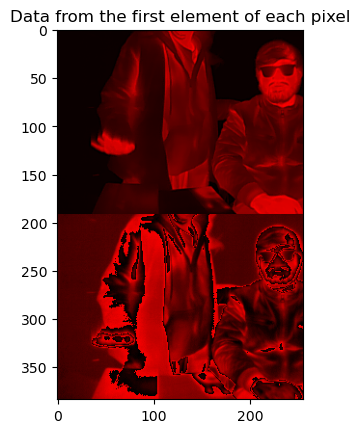

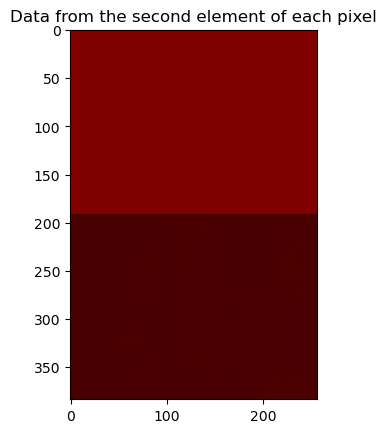

In [17]:
import matplotlib.pyplot as plt #Need to visualize the images

#We split the 2 values for each pixel into two seperate images - (384,256,3) shaped
#I put the value from the each original pixel into the first element, and the other two are fixed to 0

pic1 = np.zeros((384,256,3))
pic2 = np.zeros((384,256,3))

ma = np.max(n_frame)
mi = np.min(n_frame)
d = abs(ma-mi)

for i in range(384):
    for j in range(256):
        pic1[i,j,0] = float(n_frame[i,j,0]/d)
        pic2[i,j,0] = float(n_frame[i,j,1]/d)

p1 = plt.imshow(pic1)
plt.title("Data from the first element of each pixel")
plt.show()
plt.title("Data from the second element of each pixel")
plt.imshow(pic2)
plt.show()

- First value appears to have some real data - The image is discernable.
    - There appears to be two images packed into one - making the final resolution of each image 192x256
    - No idea yet why there are two images
- The second value in the two tuple associated with each image seems to be a fixed value (I will verify if that is true, now). Need to find out what this value means.

In [18]:
im1, im2 = np.array_split(n_frame,2) #Splitting the two images packed together in the RAW data

# (100,200) is a good point here, right on my chest. I'll try looking at values there.

print(f"Values at (100,200) in im1 -> {im1[100,200]}")
print(f"Values at (100,200) in im1 -> {im2[100,200]}")


Values at (100,200) in im1 -> [ 64 128]
Values at (100,200) in im1 -> [16 74]


Seems likely that im2 has the useful data - the values in im1 are too close.
Perhaps the best way to verify this would be to see if there is any relationship between the values in im1 and im2. If I find that they are linearly related, I can safely ignore one and use the other as my reading.

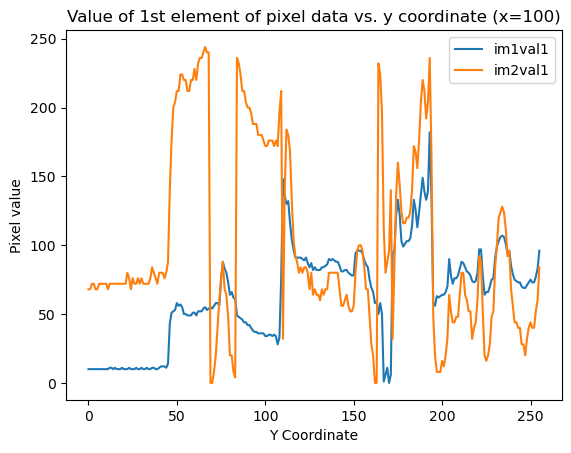

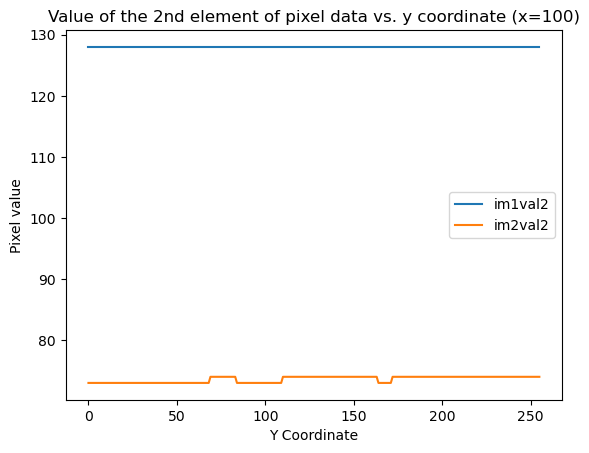

In [19]:
#As some rough visualization, we try to plot the values (all the elements, im1 and im2) along a slice - say, x=100

sl = 100

x = [i for i in range(256)]
im1val1 = [im1[sl,i,0] for i in x]
im1val2 = [im1[sl,i,1] for i in x]
im2val1 = [im2[sl,i,0] for i in x]
im2val2 = [im2[sl,i,1] for i in x]

plt.plot(x,im1val1,label='im1val1')

plt.plot(x,im2val1,label='im2val1')

plt.title("Value of 1st element of pixel data vs. y coordinate (x=100)")
plt.xlabel("Y Coordinate")
plt.ylabel("Pixel value")
plt.legend()
plt.show()

plt.plot(x,im1val2,label='im1val2')
plt.plot(x,im2val2,label='im2val2')
plt.legend()
plt.title("Value of the 2nd element of pixel data vs. y coordinate (x=100)")
plt.xlabel("Y Coordinate")
plt.ylabel("Pixel value")
plt.show()

Note how im2v2 has some fluctuations where readings are not background, whereas im1v1 remains constant throughout.

### Questions
- Is im1 derived from im2? i.e. if an im1 pixel value is $(x_1,x_2)$ and im2 pixel value is $(y_1,y_2)$, then can we always write ->
$$
x_1 = a_1  y_1 + b_1 y_2
$$
$$
x_2 = a_2 y_1 + b_2 y_2
$$
For some constant $a_i$ and $b_i$

> What if this is true? We can then safely ignore one image (as it has no information that can not be derived from the other) and use the other image for thermal measurement.

- If, say, im1 is derived from im2, then how do I derive the temperature value from the data of im2?

To do this, we employ simple multiple linear regression, and look at how accurately it can determine the linear combination coefficients.

In [10]:
#First, we prepare the data - the more the merrier! So, we do the entire frame
im1v1 = []
im1v2 = []
im2v1 = []
im2v2 = []

d1 = abs(np.max(im1)-np.min(im1))
d2 = abs(np.max(im2)-np.min(im2))

for i in range(192):
    for j in range(256):
        im1v1.append(float(im1[i,j,0])/d1)
        im1v2.append(float(im1[i,j,1])/d1)
        im2v1.append(float(im2[i,j,0])/d2)
        im2v2.append(float(im2[i,j,1])/d2)

#Need to normalise all the values, otherwise the scale differences (if any) may cause MSE to blow up

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

indep = np.zeros((49152,2))
dep = np.asarray(im1v1)
for i in range(49152):
    indep[i,0] = im2v1[i]
    indep[i,1] = im2v2[i]

#Regressing with im1v1 as dependent
model = LinearRegression()
model.fit(indep,dep)
coefficients = model.coef_
intercept = model.intercept_
score = model.score(indep,dep)
print(f"The equation of the fit is: im1v1 = {intercept:.2f} + ({coefficients[0]:.2f} * im2v1) + ({coefficients[1]:.2f} * im2v2)")
print(f"R^2 (Best fit = 1) -> {score}")
dep_pred = model.predict(indep)
mse = mean_squared_error(dep, dep_pred)
print(f"Mean Squared Error (Best Fit = 0) -> {mse}")
print(f"RMSE (Best Fit = 0) -> {np.sqrt(mse)}")

#Regressing with im1v2 as dependent
dep = np.asarray(im1v2)

model = LinearRegression()
model.fit(indep,dep)
coefficients = model.coef_
intercept = model.intercept_
score = model.score(indep,dep)
print(f"The equation of the fit is: im1v2 = {intercept:.2f} + ({coefficients[0]:.2f} * im2v1) + ({coefficients[1]:.2f} * im2v2)")
print(f"R^2 (Best fit = 1) -> {score}")
dep_pred = model.predict(indep)
mse = mean_squared_error(dep, dep_pred)
print(f"Mean Squared Error (Best Fit = 0) -> {mse}")
print(f"RMSE (Best Fit = 0) -> {np.sqrt(mse)}")

The equation of the fit is: im1v1 = -28.29 + (0.41 * im2v1) + (97.72 * im2v2)
R^2 (Best fit = 1) -> 0.9672654176291796
Mean Squared Error (Best Fit = 0) -> 0.0009505769373671344
RMSE (Best Fit = 0) -> 0.030831427754275904
The equation of the fit is: im1v2 = 0.51 + (0.00 * im2v1) + (-0.00 * im2v2)
R^2 (Best fit = 1) -> 0.0
Mean Squared Error (Best Fit = 0) -> 1.1093356479670479e-31
RMSE (Best Fit = 0) -> 3.3306690738754696e-16


Clearly, the $R^2$, MSE and RMSE are really good - we can say with confidence that:
- im1v1 is a linear combination of im2v1 and im2v2
- im1v2 seems to be constant (We don't need to worry about it - clearly im1 is generated from im2 to be used as a more contrasted display image)

Now that we have figured out that most of the useful thermal information is in the im2 matrix, we have to figure out how we can use im2v1 and im2v2 to calculate temperature of a pixel.

### Testing whether im1v2 has any useful information
Though it is unlikely (given that it is packed with another datapoint derived from the temperature data), it is best to check if it contains any data.
To do this, I will take 100 frames (will attempt to have random thermal signatures in them), select the same pixel in all of them (since the value of im1v2 is fixed across a single frame), can calculate the variance. If there is none, it means that this value is possibly useless for measurement purposes.

In [11]:
from time import sleep
frames = np.zeros(100)

for i in range(100):
    ret, fr = cam.read()
    if ret:
        fr = fr.flatten()
        fr = fr.reshape(384,256,-1)
        im, _ = np.array_split(fr,2)
        frames[i] = im[100,100,1]
    else:
        i -= 1
    sleep(0.5)

print(f"The variance in the values over 100 frames is: {np.var(frames)}")

The variance in the values over 100 frames is: 0.0


No variation in the value - We can safely ignore im1v2. It is probably just a constant value present there to conform to some RGB conversion standard.

## Pre-Calibration
Need to determine if there is some sort of USB communication being established between the TC001 Official Software and the Camera. If there is such a communication that alters the data output, and we do not know about it, it renders the entire calibration process moot.
We will be using Wireshark + USBPcap to sniff the data handled over USB, and try to see if there is any communication. If there is any, we will hopefully be able to decipher it.

**Results**: Looked over the USB communication from the software - there is no communication happening. Only descriptor requests. Safe to assume that there is no extra information being sent from the camera to the driver other than the isochronous video stream. bRequest = 68, 69 only major URB_CONTROL out packets. There are a few SET CUR requests, but I have no idea what they are setting - I can not seem to access the control over Windows.
This control is not done when the camera is running, though. Not even when it "clicks" to internally re-calibrate. I guess it is just some setup command.

## Calibration
Now that we have identified the pertinent variables, we must establish a relationship between the data supplied by the camera (im2v1, im2v2) and the temperature. From now on, for the ease of notation, I will refer to im2v1 as $x_1$ and im2v2 as $x_2$. The temperature values are controlled in data collection via the Temperature Controller. The target will be a block of copper metal, with thin black tape on it to increase emissivity of the surface.
- Collect as much data as possible as $(T, x_1, x_2)$, where $T$ is temperature
- Some exploratory data analysis: Calculate correlation coefficients between $T, x_1$, and $T, x_2$ to estimate how strongly the final reading depends on the values.
- Select a model - for all intents and purposes the camera is a black-box, and we do not know the form of $f$ such that, $Y = f(x_1, x_2)$. So we must decide on -
    - Multiple linear regression: $Y = \beta \alpha_1 x_1 + \alpha_2 x_2 + \epsilon$
    Here, $\beta$ is intercept, $\alpha_i$'s are fit coefficients, and $\epsilon$ is the error term
    - Polynomial Regression: $Y = \beta + \alpha_1 x_1 + \alpha_2 x_2 + \alpha_3 x_1^2 + \alpha_4 x_2^2 + \alpha_5 x_1 x_2 + \epsilon$
    - Generally ignoring Machine-Learning methods right now - they are pretty much black-box methods themselves. If the above do not work, it will be reasonable to just interpolate (linearly) between data points whe doing experiments in calibration range - there is no real need to use a model to predict. (Approach may change based on the results of the regressions)
- Evaluate Model:
    - Predict values using the model, and check the residual differences between the predicted and the actual values. (R2, MSE, RMSE, etc included).

Fairly general, there are no assumptions about the inner workings of the camera here.

### Data collection code
Contains PID control for the temperature controller (commands extracted from the manual), and collection of data from the camera.
Ideally, we should carry out the regression analysis for each pixel independently - as different pixels might have different responses. To that end, we will be following this procedure:
1. Position target such that all pixels are covered.
2. Set temperature of target to slightly above room temperature; Let the target equilibriate.
3. Collect readings from all pixels, tagged by picel location, for this temperature. Take several frames for each such set temperature.
4. Raise temperature of the target by a fixed amount, let it equilibriate there again, repeat procedure until maximum possible temperature is reached.

#### Code for testing connection to the controller
This will list out the devices (GPIO) on USB, and attempt to query temperature from Sensor 2. Will not crash if successful

In [ ]:
import pyvisa

rm = pyvisa.ResourceManager()
rm.list_resources()
inst = rm.open_resource('GPIB0::15::INSTR')

print(inst.query("*IDN?"))

print(inst.query("Out2.Value?"))

print(inst.query("In2.Value?"))

### Consolidated data collection code

In [ ]:
#New Imports
import pyvisa
#Old imports, just in case someone just wants to run this cell
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

#Setup pyvisa
rm = pyvisa.ResourceManager()
rm.list_resources()
inst = rm.open_resource('GPIB0::15::INSTR') #PID code the controller

#Best write a function for communication here
def set_param(cmd,val,inst=inst):
    '''
    cmd: string
    val: float
    int: PyVisa Resource Object
    Takes command, value, parses it into string and passes to PyVisa resource instance
    '''
    s = cmd + ' ' + str(val)
    inst.write(s)
    return 1

#Setup the camera
dev = 0
cam = cv2.VideoCapture(dev, cv2.CAP_ANY)

cam.set(cv2.CAP_PROP_CONVERT_RGB, 0.0)

#Setting the ramp value for the controller - fixed throughout (since we will be keeping it constant)
set_param("Out2.PID.Ramp",0.033)

#This list will hold 192x256x3 shaped numpy arrays, with the items being (x_1, x_2, temp)
data = []

exp = False #Variable controls the start of automated measurement run

#Set the range of the experiment, and temperature step (in K)
upperLim = 330
lowerLim = 300
step = 0.5
noFrames = 100 #Number of frames to take at each set temperature

testTemps = np.arange(lowerLim,upperLim,step)
maxRun = len(testTemps)
run = 0

while(cam.isOpened()):
    ret, frame = cam.read()
    #T = inst.query("In2.Value?")
    #time.sleep(1) #So that the controller has enough time to answer
    #Prints the image to screen, skips a loop if there is no frame captured for whatever reason
    if ret:
        frame = frame.flatten()
        frame = frame.reshape((384,256,-1))
        imdata, thdata = np.array_split(frame,2)

        # Convert the real image to RGB
        bgr = cv2.cvtColor(imdata,  cv2.COLOR_YUV2BGR_YUYV)
        heatmap = cv2.applyColorMap(bgr, cv2.COLORMAP_VIRIDIS)

        cv2.imshow(heatmap) #Display the heatmap - Useful for setting things up

        keyPress = cv2.waitKey(1)

        if keyPress == ord('s'): #Start the automated data collection
            exp = True
            print('STARTING COLLECTION!')
            cv2.destroyAllWindows()
            break

        if keyPress == ord('q'): #Quit the application at any given time
            cam.release()
            cv2.destroyAllWindows()
            print("BYE!")
            break
    else:
        continue
   
if exp:
    for run in maxRun:
        #Start the automated data collection run
        setTemp = testTemps[run]
        set_param("Out2.PID.setpoint",setTemp) #Setting the temperature setpoint
        print(f"STARTING WITH THE TEMPERATURE: {setTemp}K")
        old_temp = inst.query("In2.Value?")
        time.sleep(15)
        new_temp = inst.query("In2.Value?")
        time.sleep(1)
        while abs(new_temp-old_temp) > 0.1:
            print("WAITING FOR EQUILIBRIUM OF TARGET TEMP!")
            old_temp = inst.query("In2.Value?")
            time.sleep(15)
            new_temp = inst.query("In2.Value?")
            time.sleep(1)
        print("EQUILIBRIUM TEMPERATURE REACHED!")
        #Now that the target has reached a fixed temperature, we start taking data
        for i in range(noFrames):
            ret, frame = cam.read()
            if ret:
                cTemp = inst.query("In2.Value?")
                time.sleep(1)
                print(f"Taking the {i+1}th frame at temperature {cTemp}K")
                frame = frame.flatten()
                frame = frame.reshape((384,256,-1))
                imdata, thdata = np.array_split(frame,2)

                # Convert the real image to RGB
                bgr = cv2.cvtColor(imdata,  cv2.COLOR_YUV2BGR_YUYV)
                heatmap = cv2.applyColorMap(bgr, cv2.COLORMAP_VIRIDIS)

                cv2.imshow(heatmap)

                entry = np.zeros((192,256,3))

                for x in range(192):
                    for y in range(256):
                        entry[x,y,0] = thdata[x,y,0]
                        entry[x,y,1] = thdata[x,y,1]
                        entry[x,y,2] = cTemp
                
                data.append(np.copy(entry))
            else:
                i -= 1
                continue

set_param("Out2.PID.setpoint",290) #Setting back to low temp, let it cool

print("DATA COLLECTED SUCCESSFULLY!")
#Now, we just write the data to a file for analysis later
np.savez('LATEST_CALIB_DATA.npz', *data)
print("DATA WRITTEN!")